In [1282]:
import sys, os, random, re, glob, copy
import pprint as pp
#from functools import reduce

In [1283]:
#!pip3 install 'pyLDAvis>3,<3.4'

In [1284]:
#!pip3 install -U plotly
#!pip3 install -U seaborn
#!pip3 install -U adjustText

In [1285]:
## NBConvert のために
#!pip install -U nbconvert
#!pip install -U pyppeteer

Settings for data

In [1286]:
## 一般設定
verbose   = False
save_data = False

## 分野の設定
domains = { 'medical'    : True,
            'mce'        : False,
            'economic'   : True,
            'juridical'  : True,
            'publishing' : True,
            'cooking'    : True
            }

target_vars = ['word']
target_vars.extend(domains.keys())
print(f"target_vars: {target_vars}")

## 分野の選択
selected_domains = { k: v for k, v in domains.items() if v == True } # as dictionary
print(f"selected domains: {[ k for k, v in selected_domains.items() if v == True ]}")

## 分野毎の事例数の均衡化
if len(selected_domains) > 1:
    balanced = True
else:
    balanced = False
print(f"domain balancing: {balanced}")

target_vars: ['word', 'medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking']
selected domains: ['medical', 'economic', 'juridical', 'publishing', 'cooking']
domain balancing: True


In [1287]:
## colormap
colors =  [ 'deeppink', 'pink',  'orange', 'green', 'paleturquoise', 'powderblue', 'gray' ]
colors_mapped = list(zip(colors, domains)) # Crucially, list(...)
colormap = { i : x[0] for i, x in enumerate(colors_mapped) if x[-1] in selected_domains }
print(colormap)
xcolormap = { i : y for i, y in enumerate(colors_mapped) if y[-1] in selected_domains }
for k, v in xcolormap.items():
    print(f"分野 id: {k}, 名称: {v[-1]}".ljust(16) + " => ".rjust(-10) + f"色: {v[0]}")

{0: 'deeppink', 2: 'orange', 3: 'green', 4: 'paleturquoise', 5: 'powderblue'}
分野 id: 0, 名称: medical => 色: deeppink
分野 id: 2, 名称: economic => 色: orange
分野 id: 3, 名称: juridical => 色: green
分野 id: 4, 名称: publishing => 色: paleturquoise
分野 id: 5, 名称: cooking => 色: powderblue


Settings for LDA

In [1288]:
## LDA の基本設定

## topic 数の指定
n_topics = 10 # 変更可能: 値が大きい方が分類は詳細だが，大分類は収束しない

## doc, term の設定
doc_type    = 'word'
term_size   = 'character'
term_types  = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'skippy4gram' ]  
term_type   = term_types[-1]
print(f"used term: {term_type}")

## n-gram を包括 (n-gram が (n-1)を真に含む) 型にするかどうか
## 包括型にしないと，n が大きくなった時にエンコードされない事例が生じる
ngram_is_inclusive = True

## doc の最大長と最小長さ
discard_too_long = True
max_doc_length = 13 # effective if discard_too_long
discard_too_short = False
min_doc_length =  3 # effective if discard_too_short

## カタカナを含む語の除外
discard_kana_overloaded = False
kana_tolerance = 0.75

## skippy n-gram が結びつく最長の gram数: bigram と trigram で共有
max_distance_val = round(max_doc_length * 0.75)
print(f"skippy n-gram max_distance: {max_distance_val}")

## skippy n-gram の記号
gap_mark = "…"

## Raw term の濾過
remove_highly_frequent_unigrams = False
cutoff_rate = 0.001 # discard the most frequest <rate> of the terms 

## DTM のterm 濾過の設定
minfreq = 1 # 最低頻度
abuse_threshold = 0.02 # 値が小さい方が濾過力が大きい．0.1 は十分に大きい．

used term: skippy4gram
skippy n-gram max_distance: 10


Settings for tSNE

In [1289]:
### tSNE の設定

## topic の tSNE 用の設定
top_perplexity_reduct_rate = 0.5
print(f"top_perplexity_rate: {top_perplexity_reduct_rate}")

## doc の tSNE 用の設定
doc_perplexity_reduct_rate1 = 0.33 # topic数に依存する場合
doc_perplexity_reduct_rate2 = 0.1 # doc数に依存する場合

## doc_perplexity を n_topics に基づいて決めるか事例数に基づいて決めるかの選択
doc_perplexity_depends_on_n_topics = False
if doc_perplexity_depends_on_n_topics:
    doc_perplexity_reduc_rate = doc_perplexity_reduct_rate1
else:
    doc_perplexity_reduct_rate = doc_perplexity_reduct_rate2
print(f"doc_perplexity_reduct_rate: {doc_perplexity_reduct_rate}")

top_perplexity_rate: 0.5
doc_perplexity_reduct_rate: 0.1


In [1290]:
## load data to process
from pathlib import Path
import pprint as pp

wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
print(f"The following {len(dirs)} directories are potential targets:")
pp.pprint(sorted(dirs))

The following 6 directories are potential targets:
[PosixPath('.git'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('__pycache__'),
 PosixPath('results'),
 PosixPath('saves'),
 PosixPath('terms-source')]


In [1291]:
## list up files in target directory 
targetdir = "terms-source" # can be changed
files = sorted(list(wd.glob(f"{targetdir}/terms*.xlsx")))
#
print(f"\n{targetdir} contains {len(files)} files to process")
pp.pprint(files)


terms-source contains 7 files to process
[PosixPath('terms-source/terms-cooking-v1a.xlsx'),
 PosixPath('terms-source/terms-economic-v1b.xlsx'),
 PosixPath('terms-source/terms-juridical-v1a2.xlsx'),
 PosixPath('terms-source/terms-juridical-v1b2.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-v1b.xlsx'),
 PosixPath('terms-source/terms-publishing-v1b.xlsx')]


In [1292]:
## 本来のファイルの処理
files_core = [ file for file in files if not "juridical-v1b2" in str(file) ]
files_core

[PosixPath('terms-source/terms-cooking-v1a.xlsx'),
 PosixPath('terms-source/terms-economic-v1b.xlsx'),
 PosixPath('terms-source/terms-juridical-v1a2.xlsx'),
 PosixPath('terms-source/terms-mce-v2b.xlsx'),
 PosixPath('terms-source/terms-medical-v1b.xlsx'),
 PosixPath('terms-source/terms-publishing-v1b.xlsx')]

In [1293]:
## 必要に応じて次を実行
#!pip install -U openpyxl

In [1294]:
import numpy as np
import pandas as pd

raw_dfs = [ ]
for file in files_core:
    ## 出版用語のsampled = 1 の場合のみ選別
    if "publishing" in str(file):
        d = pd.read_excel(file) # requires openpyxl to be installed
        d = d[d['local.id'] != None]
        d = d[d['unique'] == 1] # 重複出現する語を除外
        d = d[d['sampled'] == 1]
        raw_dfs.append(d)
    else:
        d = pd.read_excel(file)
        d = d[d['local.id'] != None]
        d = d[d['unique'] == 1] # 重複出現する語を除外
        raw_dfs.append(d) # requires openpyxl to be installed
raw_dfs

[      local.id        word  unique  medical  mce  economic  juridical  \
 0          1.0      8番らーめん     1.0      0.0  0.0       0.0        0.0   
 1          2.0      ABCスープ     1.0      0.0  0.0       0.0        0.0   
 2          3.0        Aランチ     1.0      0.0  0.0       0.0        0.0   
 3          4.0      BTSサラダ     1.0      0.0  0.0       0.0        0.0   
 4          5.0  SIOコンコーンカツ     1.0      0.0  0.0       0.0        0.0   
 ...        ...         ...     ...      ...  ...       ...        ...   
 4922    4987.0       黒豆サラダ     1.0      0.0  0.0       0.0        0.0   
 4923    4988.0     黒部ダムカレー     1.0      0.0  0.0       0.0        0.0   
 4924    4989.0         龍眼卵     1.0      0.0  0.0       0.0        0.0   
 4925    4990.0      龍馬ギョーザ     1.0      0.0  0.0       0.0        0.0   
 4926    4991.0       龍馬タタキ     1.0      0.0  0.0       0.0        0.0   
 
       publishing  cooking  valid     rid  subsampled  note  
 0            0.0      1.0    1.0  4864.0       

In [1295]:
## DataFrame 構築
check = False
dfs = [ ]
for dfx in raw_dfs:
    d = dfx[target_vars]
    if check:
        print(d)
    dfs.append(d)
#
df0 = pd.concat(dfs)
if check:
    df0

In [1296]:
## 追加ファイルの処理
added_file = [ file for file in files if not file in files_core ][0]
print(added_file)
raw_juridic2 = pd.read_excel(added_file)

## juridical の sampled = 1 で unique = 1 の事例のみを選別
raw_juridic2 = raw_juridic2[ (raw_juridic2['sampled'] == 1) & (raw_juridic2['unique'] == 1) ]
raw_juridic2 = raw_juridic2[ target_vars ]

##
add_juridic2 = True
if add_juridic2:
    df0 = pd.concat([df0, raw_juridic2])
#
df0

terms-source/terms-juridical-v1b2.xlsx


,word,medical,mce,economic,juridical,publishing,cooking
0,8番らーめん,0.0,0.0,0.0,0.0,0.0,1.0
1,ABCスープ,0.0,0.0,0.0,0.0,0.0,1.0
2,Aランチ,0.0,0.0,0.0,0.0,0.0,1.0
3,BTSサラダ,0.0,0.0,0.0,0.0,0.0,1.0
4,SIOコンコーンカツ,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
870,訴訟指揮,0.0,0.0,0.0,1.0,0.0,0.0
871,上告審,0.0,0.0,0.0,1.0,0.0,0.0
874,制限行為能力者,0.0,0.0,0.0,1.0,0.0,0.0
875,被控訴人,0.0,0.0,0.0,1.0,0.0,0.0


Filtering

In [1297]:
## 長過ぎる語と短過ぎる語を除外
original_len = len(df0)
if discard_too_long:
    df0 = df0[ [ True if len(str(x)) <= max_doc_length else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they are longer than {max_doc_length}")

if discard_too_short:
    df0 = df0[ [ True if len(str(x)) >= min_doc_length else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they are shorter than {min_doc_length}")

11838: 103 cases are removed because they are longer than 13
11838: 103 cases are removed because they are shorter than 3


In [1298]:
## カタカナ/ひらがなを多く含む語の除外
def katakana_count(s: str):
    import regex
    p = regex.compile(r'\p{Script=Katakana}')
    return len(p.findall(s))

def hiragana_count(s: str):
    import regex
    p = regex.compile(r'\p{Script=Hiragana}')
    return len(p.findall(s))
#
original_len = len(df0)    
if discard_kana_overloaded:
    ## katakana
    df0 = df0[ [ True if katakana_count(str(x))/len(str(x)) <= kana_tolerance else False for x in df0[doc_type] ] ]
    ## hiragana
    df0 = df0[ [ True if hiragana_count(str(x))/len(str(x)) <= kana_tolerance else False for x in df0[doc_type] ] ]
#
current_len = len(df0)
print(f"{current_len}: {original_len - current_len} cases are removed because they contain too many kana characters")

11838: 0 cases are removed because they contain too many kana characters


In [1299]:
## 色分けの為の domain_id を定義
check = False
domain_list = [ ]
for i, row in df0.iterrows():
    if check:
        print(f"{row['medical']}, {row['mce']}, {row['economic']}, {row['juridical']}, {row['publishing']}, {row['cooking']}" )
    if   row['medical'] == 1:    domain_list.append(0)
    elif row['mce'] == 1:        domain_list.append(1)
    elif row['economic'] == 1:   domain_list.append(2)
    elif row['juridical'] == 1:  domain_list.append(3)
    elif row['publishing'] == 1: domain_list.append(4)
    elif row['cooking'] == 1:    domain_list.append(5)
    else:                        domain_list.append(6)
#
df0['domain_id'] = domain_list

## domain の事例数の確認
df0['domain_id'].value_counts().sort_index()

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_4130/2806462027.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



domain_id
0    3468
1     820
2     507
3     632
4    1520
5    4891
Name: count, dtype: int64

In [1300]:
## 重複の削除
df0 = df0.drop_duplicates(subset = [doc_type], keep = 'first')

In [1301]:
## 分野の事例数の確認
print(f"Effective domains")
S = [ ]
for domain_name in selected_domains.keys():
    print(f"domain_name: {domain_name}")
    S.append(df0[df0[domain_name] == 1])
#
df0 = pd.concat(S, axis = 0)
df0

Effective domains
domain_name: medical
domain_name: economic
domain_name: juridical
domain_name: publishing
domain_name: cooking


,word,medical,mce,economic,juridical,publishing,cooking,domain_id
0,1型糖尿病,1.0,0.0,0.0,0.0,0.0,0.0,0
1,2型糖尿病,1.0,0.0,0.0,0.0,0.0,0.0,0
2,HIV感染,1.0,0.0,0.0,0.0,0.0,0.0,0
3,アキレス腱挫傷,1.0,0.0,0.0,0.0,0.0,0.0,0
4,アキレス腱断裂手術,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
4922,黒豆サラダ,0.0,0.0,0.0,0.0,0.0,1.0,5
4923,黒部ダムカレー,0.0,0.0,0.0,0.0,0.0,1.0,5
4924,龍眼卵,0.0,0.0,0.0,0.0,0.0,1.0,5
4925,龍馬ギョーザ,0.0,0.0,0.0,0.0,0.0,1.0,5


In [1302]:
## 分野指定の整合性の確認
df0['checksum'] = df0[['medical', 'mce', 'economic', 'juridical', 'publishing', 'cooking']].sum(axis = 1)
len(df0[df0['checksum'] == 0])
len(df0[df0['checksum'] > 1])

0

In [1303]:
## 混合のための割合を調整: 事例数を揃えるために復元抽出の設定にしているので
## 事例の重複が起きる
if balanced:
    sample_size = 500
    # Medical
    if 'medical' in selected_domains.keys():
        med_sampled = df0[ df0['medical'] == 1 ].sample(sample_size, replace = True)
    else:
        med_sampled = None
    # MCE
    if 'mce' in selected_domains.keys():
        mce_sampled = df0[ df0['mce'] == 1 ].sample(sample_size, replace = True)
    else:
        mce_sampled = None
    # Juridical
    if 'juridical' in selected_domains.keys():
        jurid_sampled = df0[ df0['juridical'] == 1 ].sample(sample_size, replace = True)
    else:
        jurid_sampled = None
    # Publishing
    if 'publishing' in selected_domains.keys():
        pub_sampled = df0[ df0['publishing'] == 1 ].sample(sample_size, replace = True)
    else:
        pub_sampled = None
    # Cooking
    if 'cooking' in selected_domains.keys():
        cook_sampled = df0[ df0['cooking'] == 1 ].sample(sample_size, replace = True)
    else:
        cook_sampled = None
    ## integration
    df0 = pd.concat([med_sampled, mce_sampled, jurid_sampled, pub_sampled, cook_sampled,
                 df0[df0['economic'] == 1]])

## domain の事例数の確認
df0['domain_id'].value_counts().sort_index()

domain_id
0    500
2    507
3    500
4    500
5    500
Name: count, dtype: int64

In [1304]:
## 順序をランダマイズし df0 を df として再定義
import sklearn.utils
df = sklearn.utils.shuffle(df0)

In [1305]:
## 設定の確認
doc_type
df[['word', 'domain_id', 'checksum']]

,word,domain_id,checksum
287,変動金利,2,1.0
1887,潜伏感染,0,1.0
111,民事法律扶助,3,1.0
3912,煮干しそば,5,1.0
931,ホットタイプ,4,1.0
...,...,...,...
75,オープン市場,2,1.0
412,立ち会い,2,1.0
661,前立腺結核,0,1.0
586,付従性,3,1.0


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_4130/2431902341.py:13: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



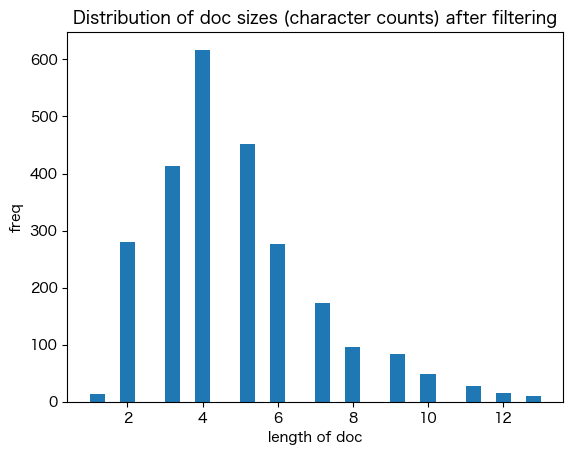

In [1306]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

d = [ len(x) for x in df[doc_type] ]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(d, bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of doc sizes (character counts) after filtering")
fig.show()

DTM 構築

In [1307]:
## 共有される名称の定義
docs = df[doc_type]
docs

287       変動金利
1887      潜伏感染
111     民事法律扶助
3912     煮干しそば
931     ホットタイプ
         ...  
75      オープン市場
412       立ち会い
661      前立腺結核
586        付従性
308       法定追認
Name: word, Length: 2507, dtype: object

In [1308]:
## 1gram 生成
check = False
unigrams = [ ]
for x in docs:
    if check: print(x)
    u = list(x)
    if len(u) > 0:
        unigrams.append(u)
#
random.sample(unigrams, 3)

[['示', '談'], ['エ', 'ビ', 'チ', 'リ'], ['原', '発', '性', '認', '知', '症']]

In [1309]:
## 名称の設定
df['1gram'] = unigrams
df

,word,medical,mce,economic,juridical,publishing,cooking,domain_id,checksum,1gram
287,変動金利,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,"[変, 動, 金, 利]"
1887,潜伏感染,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,"[潜, 伏, 感, 染]"
111,民事法律扶助,0.0,0.0,0.0,1.0,0.0,0.0,3,1.0,"[民, 事, 法, 律, 扶, 助]"
3912,煮干しそば,0.0,0.0,0.0,0.0,0.0,1.0,5,1.0,"[煮, 干, し, そ, ば]"
931,ホットタイプ,0.0,0.0,0.0,0.0,1.0,0.0,4,1.0,"[ホ, ッ, ト, タ, イ, プ]"
...,...,...,...,...,...,...,...,...,...,...
75,オープン市場,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,"[オ, ー, プ, ン, 市, 場]"
412,立ち会い,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,"[立, ち, 会, い]"
661,前立腺結核,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,"[前, 立, 腺, 結, 核]"
586,付従性,0.0,0.0,0.0,1.0,0.0,0.0,3,1.0,"[付, 従, 性]"


In [1310]:
## 1gram の頻度を取得

import collections
unigrams_all = [ ]
[ unigrams_all.extend(L) for L in df['1gram'] ]

unigram_freqs = collections.Counter(unigrams_all)
unigram_freqs.most_common(20)

[('ー', 271),
 ('ン', 186),
 ('性', 161),
 ('の', 134),
 ('り', 101),
 ('ス', 100),
 ('ト', 88),
 ('し', 86),
 ('ル', 86),
 ('イ', 83),
 ('ラ', 81),
 ('き', 80),
 ('ク', 72),
 ('ア', 72),
 ('ッ', 66),
 ('シ', 65),
 ('ん', 60),
 ('産', 59),
 ('フ', 59),
 ('タ', 56)]

In [1311]:
## 高頻度 1gram フィルターの産物を確認
highly_frequents = sorted(unigram_freqs, reverse = True)[:round(cutoff_rate * len(df['1gram']))]
highly_frequents

['／', '％', '齢']

In [1312]:
## 高頻度 1-gram の除外

if remove_highly_frequent_unigrams:
    df['1gram'].apply(lambda x:
                     [ u for u in df['1gram'] if not u in highly_frequents ] )

In [1313]:
## bigram 生成
check = False
n = 2
bigrams = [ ]
for doc in docs:
    if check: print(doc)
    size = len(doc)
    if size < n:
         bigrams.append([doc])
    else:
        L = [ ]
        for i in range(size - n + 1):
            x = doc[ i:i+n ]
            if check: print(x)
            if len(x) == n:
                L.append(x)
        if len(L) > 0:
            bigrams.append(L)

## 包括的 2gramの生成
if ngram_is_inclusive:
    for i, b in enumerate(bigrams):
        b.extend(unigrams[i])
#
random.sample(bigrams, 3)

[['不良', '良債', '債権', '不', '良', '債', '権'], ['洋丁', '洋', '丁'], ['松露', '松', '露']]

In [1314]:
## 変数の追加
df['2gram'] = bigrams
if verbose:
    df

In [1315]:
## trigram 生成
check = False
n = 3
trigrams = [ ]
for doc in docs:
    if check: print(f"doc: {doc}")
    size = len(doc)
    if size < n:
        trigrams.append([doc]) 
    else:
        L = [ ]
        for i in range(size - n + 1):
            x = doc[ i:i+n ]
            if check: print(f"x: {x}")
            if len(x) == n:
                L.append(x)
        if check: print(f"L: {L}")
        #if len(L) > 0:
        trigrams.append(L)

## 包括的 3gramの生成
if ngram_is_inclusive:
    for i, t in enumerate(trigrams):
        t.extend(bigrams[i])
#
random.sample(trigrams, 3)

[['流動性',
  '動性の',
  '性のわ',
  'のわな',
  '流動',
  '動性',
  '性の',
  'のわ',
  'わな',
  '流',
  '動',
  '性',
  'の',
  'わ',
  'な'],
 ['国際石',
  '際石油',
  '石油資',
  '油資本',
  '国際',
  '際石',
  '石油',
  '油資',
  '資本',
  '国',
  '際',
  '石',
  '油',
  '資',
  '本'],
 ['地方裁', '方裁判', '裁判所', '地方', '方裁', '裁判', '判所', '地', '方', '裁', '判', '所']]

In [1316]:
## 変数の追加
df['3gram'] = trigrams
if verbose:
    df

In [1317]:
## skippy 2grams の生成
import ngrams_skippy
skippy2grams = [ ngrams_skippy.gen_skippy2grams(x, missing_mark = gap_mark,
                                                   max_distance = max_distance_val,
                                                   minimize = False,
                                                   check = False)
                for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy2grams):
        b2.extend(unigrams[i])
#
random.sample(skippy2grams, 2)

[['消費', '消…貸', '消…借', '費貸', '費…借', '貸借', '消', '費', '貸', '借'],
 ['カー',
  'カ…ド',
  'カ…破',
  'カ…産',
  'ード',
  'ー…破',
  'ー…産',
  'ド破',
  'ド…産',
  '破産',
  'カ',
  'ー',
  'ド',
  '破',
  '産']]

In [1318]:
## 変数の追加
df['skippy2gram'] = skippy2grams
if verbose:
    df

In [1319]:
## skippy 3grams
skippy3grams = [ ngrams_skippy.gen_skippy3grams(x,
                                                        missing_mark = gap_mark,
                                                        max_distance = max_distance_val,
                                                        minimize = False,
                                                        check = False)
                for x in df[doc_type] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy3grams):
        t2.extend(skippy2grams[i])
#
random.sample(skippy3grams, 2)

[['平行折',
  '平行…り',
  '平…折り',
  '行折り',
  '平行',
  '平…折',
  '平…り',
  '行折',
  '行…り',
  '折り',
  '平',
  '行',
  '折',
  'り'],
 ['真空包',
  '真空…装',
  '真…包装',
  '空包装',
  '真空',
  '真…包',
  '真…装',
  '空包',
  '空…装',
  '包装',
  '真',
  '空',
  '包',
  '装']]

In [1320]:
## 変数の追加
df['skippy3gram'] = skippy3grams
if verbose:
    df

In [1321]:
## skippy 4grams
check = True
skippy4grams = [ ngrams_skippy.gen_skippy4grams(x,
                                                        missing_mark = gap_mark,
                                                        max_distance = max_distance_val,
                                                        minimize = False,
                                                        check = False)
                for x in df[doc_type] ]

## 包括的 skippy 4-grams の生成
if ngram_is_inclusive:
    for i, q2 in enumerate(skippy4grams):
        q2.extend(skippy3grams[i])
#
random.sample(skippy4grams, 2)

[['メール便',
  'メール',
  'メー…便',
  'メ…ル便',
  'ール便',
  'メー',
  'メ…ル',
  'メ…便',
  'ール',
  'ー…便',
  'ル便',
  'メ',
  'ー',
  'ル',
  '便'],
 ['経済同友',
  '経済同…会',
  '経済…友会',
  '経…同…友会',
  '済同友会',
  '経済同',
  '経済…友',
  '経済…会',
  '経…同友',
  '経…同…会',
  '経…友会',
  '済同友',
  '済同…会',
  '済…友会',
  '同友会',
  '経済',
  '経…同',
  '経…友',
  '経…会',
  '済同',
  '済…友',
  '済…会',
  '同友',
  '同…会',
  '友会',
  '経',
  '済',
  '同',
  '友',
  '会']]

In [1322]:
check = False
if check:
    pp.pprint(random.sample(skippy4grams, 10))

In [1323]:
## 変数の追加
df['skippy4gram'] = skippy4grams
if verbose:
    df

In [1324]:
## 使ったデータの保存
if save_data:
    import datetime as dt
    ct = dt.datetime.now()
    ## Pandas で .csv として
    output_fn1 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".csv"
    print(f"saving data to {output_fn1}")
    import pandas as pd
    df.to_csv(output_fn1)
    ## pickle.dump(..)で
    output_fn2 = f"saves/mixed-terms-filtered-{ct.date()}-{str(ct.time())[:2]}" + ".p"
    import pickle
    print(f"saving data to {output_fn2}")
    with open(output_fn2, "wb") as f:
        pickle.dump(df, f)

In [1325]:
## 解析対象の確認
bots = df[term_type]
bots

287     [変動金利, 変動金, 変動…利, 変…金利, 動金利, 変動, 変…金, 変…利, 動金,...
1887    [潜伏感染, 潜伏感, 潜伏…染, 潜…感染, 伏感染, 潜伏, 潜…感, 潜…染, 伏感,...
111     [民事法律, 民事法…扶, 民事法…助, 民事…律扶, 民事…律…助, 民事…扶助, 民…法...
3912    [煮干しそ, 煮干し…ば, 煮干…そば, 煮…し…そば, 干しそば, 煮干し, 煮干…そ, ...
931     [ホットタ, ホット…イ, ホット…プ, ホッ…タイ, ホッ…タ…プ, ホッ…イプ, ホ…ト...
                              ...                        
75      [オープン, オープ…市, オープ…場, オー…ン市, オー…ン…場, オー…市場, オ…プ...
412     [立ち会い, 立ち会, 立ち…い, 立…会い, ち会い, 立ち, 立…会, 立…い, ち会,...
661     [前立腺結, 前立腺…核, 前立…結核, 前…腺…結核, 立腺結核, 前立腺, 前立…結, ...
586                      [付従性, 付従性, 付従, 付…性, 従性, 付, 従, 性]
308     [法定追認, 法定追, 法定…認, 法…追認, 定追認, 法定, 法…追, 法…認, 定追,...
Name: skippy4gram, Length: 2507, dtype: object

In [1326]:
## stopwords を除外
discarded = [ '腫瘍', '性', '炎', '血', '腫', '瘍', 'の' ]

remove_stopwords = False
if remove_stopwords:
    bows = [ [ x for x in bot if x not in discarded ] for bot in bots ]
#
if verbose:
    random.sample(list(bots), 3)

LDA を実行

In [1327]:
## LDA 構築の基になる dictionary = document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<109708 unique tokens: ['利', '動', '動…利', '動金', '動金利']...>


In [1328]:
## 構造の確認
for k in random.sample(diction.keys(), 20):
    print(f"index: {k} ; term: {diction[k]}")

index: 59950 ; term: サ…ダ…取
index: 82584 ; term: 性肺…維
index: 14204 ; term: お…ろ
index: 75904 ; term: 経…道…前…度
index: 88843 ; term: 黄金
index: 22470 ; term: ゃ…ー
index: 81154 ; term: 染…心
index: 96318 ; term: 体…中
index: 96616 ; term: の秩序…善
index: 30321 ; term: のき…タ…ジ
index: 57644 ; term: 多…性…腫骨
index: 102924 ; term: 銀…の固…業
index: 109256 ; term: ッ…制
index: 55291 ; term: ア…果
index: 94778 ; term: 感圧性
index: 26467 ; term: 上骨…関節
index: 94259 ; term: グッ…ル…ン
index: 95132 ; term: そや…ハ…バ
index: 104115 ; term: 団方式
index: 103937 ; term: 合同会


In [1329]:
## diction の検査
import pandas as pd
from operator import attrgetter
from collections import namedtuple

freq_record = namedtuple('record', ['term', 'freq'])
term_freqs = [ freq_record(*x) for x in diction.most_common() ] ## most_common allows access to frequencies
terms_freqs = sorted(term_freqs, key=attrgetter('freq'), reverse=True)

## term の頻度順位で上位30件
term_freqs[:20]

[record(term='ー', freq=271),
 record(term='ン', freq=186),
 record(term='性', freq=161),
 record(term='の', freq=134),
 record(term='り', freq=101),
 record(term='ス', freq=100),
 record(term='ト', freq=88),
 record(term='し', freq=86),
 record(term='ル', freq=86),
 record(term='イ', freq=83),
 record(term='ラ', freq=81),
 record(term='き', freq=80),
 record(term='ク', freq=72),
 record(term='ア', freq=72),
 record(term='ッ', freq=66),
 record(term='シ', freq=65),
 record(term='ー…ン', freq=64),
 record(term='ん', freq=60),
 record(term='本', freq=59),
 record(term='産', freq=59)]

In [1330]:
## 頻度1 のterm の個数
hapax = [ record for record in term_freqs if record.freq == 1]
len(hapax)

90830

In [1331]:
## 頻度1 の term のサンプル20件
random.sample(hapax, 20)

[record(term='胞…ナ', freq=1),
 record(term='ー…命', freq=1),
 record(term='ンス…ント', freq=1),
 record(term='公…発援', freq=1),
 record(term='日本…同', freq=1),
 record(term='トレ…シ…パ', freq=1),
 record(term='光…ィス', freq=1),
 record(term='罪被害…連', freq=1),
 record(term='働三', freq=1),
 record(term='性…ち', freq=1),
 record(term='端…損傷', freq=1),
 record(term='公の…又', freq=1),
 record(term='ル3', freq=1),
 record(term='紙員', freq=1),
 record(term='券…法', freq=1),
 record(term='髄硬…断', freq=1),
 record(term='いばらも', freq=1),
 record(term='SE…地…ラ', freq=1),
 record(term='4…ジ…リ…本', freq=1),
 record(term='骨…出', freq=1)]

In [1332]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction) # 予備の生成

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = minfreq, no_above = abuse_threshold)

## check
print(diction_copy)

Dictionary<100000 unique tokens: ['利', '動', '動…利', '動金', '動金利']...>


In [1333]:
## データを選択
diction = diction_copy # 名前を元に戻す

## gensim の用 corpusの構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
print(f"Number of documents: {len(corpus)}")

Number of documents: 2507


In [1334]:
## check
if verbose:
    print(random.sample(corpus, 5))

In [1335]:
## LDA モデルの構築
from gensim.models import LdaModel
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(lda)

LdaModel<num_terms=100000, num_topics=10, decay=0.5, chunksize=2000>


In [1336]:
## 結果の検査
sample_n = 3
for doc in random.sample(list(df[doc_type]), sample_n):
    print(doc)
    p_dist = lda.get_document_topics(diction.doc2bow([f"{doc}"]), minimum_probability = 0)
    print(p_dist)
    print(f"sums up to: {sum(p_dist[1])} over {len(p_dist)} topics")

マネーサプライ
[(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
sums up to: 1.1000000014901161 over 10 topics
なめろう丼
[(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
sums up to: 1.1000000014901161 over 10 topics
せいだのたまじ
[(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)]
sums up to: 1.1000000014901161 over 10 topics


In [1337]:
%%capture --no-display

## lda のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 20 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10
0,外,調,プ,け,義,見,い,症,中,瘍
1,国,状,者,会,う,上,ジ,ー…ン,薬,腫
2,会,間,ま,レ…タ,ム,台,エ,投資,子,腫瘍
3,紙,訴状,ロ,皮,正,骨,ロ,下痢症,業,切り
4,帯,パ,ン…ー,つ,テ,折,痛,資,口,ール
5,行,縮,ま…り…司,スタ,機,付,カ,性…症,剤,ロ
6,付け,情状,ま…寿司,機,上,天,エ…ー,耳,ン…ー,延焼
7,疱,手,ま…り…寿司,艶鏝,主,当…り,風,痢,ば,ブ
8,疹,ぎ,ま…司,付,経,見当,無罪,下…症,色,実子
9,疱疹,資源,ま…寿,ス…ー,ま,見当…り,ー…ー,下痢,判,ズ


LDAvis の実行

In [1338]:
%%capture --no-display

## pyLDAvis を使った結果 D_lda の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"pyLDAvis installed version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_MMDS = False
use_tsne = False
if use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds', n_jobs = 1, sort_topics = False)
elif use_tsne:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne', n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [1339]:
## LDA がD に対して生成した topics の弁別性を確認

## 得られたtopics を確認
topic_dist = lda.get_topics()

## 型は numpy.ndarry
type(topic_dist)

numpy.ndarray

In [1340]:
if check:
    random.sample(list(topic_dist), 5)

In [1341]:
## 検査 1
## topic ごとに分布の和を取る
topic_dist.sum(axis = 1)

array([1.0000001, 1.       , 1.       , 1.0000001, 1.       , 0.9999999,
       1.0000001, 1.0000001, 1.0000001, 0.9999998], dtype=float32)

In [1342]:
## 検査 2
## 総和を求める: n_topics に (ほぼ) 等しいなら正常
round(topic_dist.sum())

10

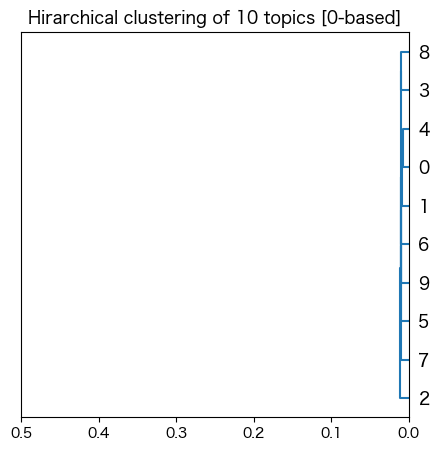

In [1343]:
## D_topic_dist を使った topic の階層クラスタリング

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 作図範囲の指定
plt.figure(figsize = (5, 5))

## 距離行列の生成
top_linkage = linkage(topic_dist, method = 'ward', metric = 'euclidean')
dendrogram(top_linkage, orientation = 'left')

## 作図
plt.xlim(0.5, 0) # 異なる分析に比較を楽にするために，x軸の大きさを固定
plt.title(f"Hirarchical clustering of {n_topics} topics [0-based]")
plt.show()

tSNE on topics

In [1344]:
## tSNE を使った topic のクラスタリング

import sklearn.manifold
## reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い

relative = True
if relative:
    #top_perplexity_reduct_rate = 0.5 # 定義は先頭に移動
    top_perplexity_val = round(n_topics * top_perplexity_reduct_rate)
else:
    top_perplexity_val = 5 # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")

## 3D version
top_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = top_perplexity_val, n_iter = 1000)

top_perplexity_val: 5


In [1345]:
## topic_dist データに適用 topic_dist のグループ化 (3D)
topic_tsne_3d = top_tSNE_3d.fit_transform(topic_dist)

In [1346]:
## 必要に応じて Plotly を導入
#!pip3 install -U plotly

In [1347]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 変数の指定
d1, d2, d3 = topic_tsne_3d[:,0], topic_tsne_3d[:,1], topic_tsne_3d[:,2]
fig = go.Figure(data = [go.Scatter3d(x = d1, y = d2, z = d3,
                                     mode = 'markers', marker = dict(size = 7)) ])

## 3D 散布図にラベルを追加する処理は未実装
#fig.update_traces(text = [ str(x) for x in range(len(topic_dist))])
title_val = f"tSNE 3D (ppl: {top_perplexity_val}) of {term_type}-based LDA ({n_topics} topics)"
fig.update_layout(title = dict(text = title_val),
                  autosize = False, width = 600, height = 600,)
fig.show()

In [1348]:
## 構築した LDA モデルを使って文(書)を分類する
##
## .get_document_topics(..) は　minimu_probability = 0としないと
## topic の値が小さい場合に値を返さないので，

## パラメター
ntopics = n_topics # LDA の構築の最に指定した値を使う
#
check      = False
deep_check = False
#
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    if deep_check:
        print(f"i: {i}")
        print(f"doc: {doc}")
        print(f"bot: {bot}")
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check: print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

2507

In [1349]:
## 確認
if verbose:
    random.sample(encoding, 2)

In [1350]:
## 値がほぼ事例数なら正常
#sum([ [ y[1] for y in x ] for x in encoding ])
sum([ round(sum(map(lambda x: x[1], x)), 0) for x in encoding ])

2507.0

In [1351]:
## tuple なので map(..) が必要

#df['enc'] = np.array(encoding) # This flattens arrays
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
#
df['enc']

287     [0.00071916985, 0.00071916985, 0.00071916985, ...
1887    [0.00067077886, 0.00067077886, 0.00067077886, ...
111     [0.00017966676, 0.998383, 0.00017966676, 0.000...
3912    [0.00034774072, 0.00034774072, 0.00034774072, ...
931     [0.00019520822, 0.00019520822, 0.00019520822, ...
                              ...                        
75      [0.0004530106, 0.43160892, 0.56476694, 0.00045...
412     [0.001961742, 0.001961742, 0.001961742, 0.3486...
661     [0.0007642086, 0.0007642086, 0.0007642086, 0.4...
586     [0.009092591, 0.009092591, 0.009092591, 0.9181...
308     [0.0006626216, 0.0006626216, 0.0006626216, 0.0...
Name: enc, Length: 2507, dtype: object

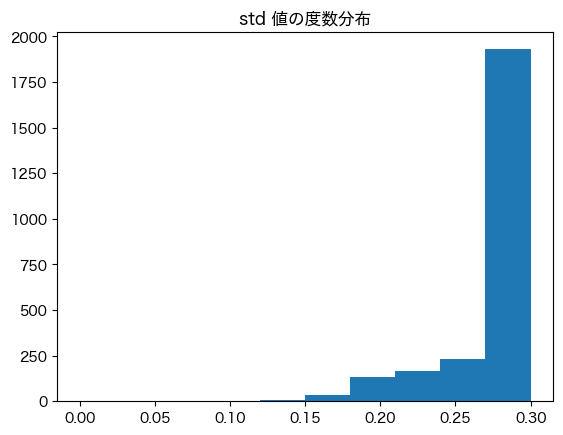

In [1352]:
## エンコーディングのstd の分布を見る
import numpy as np
from matplotlib import pyplot as plt
## 日本語表示のための設定
plt.rcParams["font.family"] = "Hiragino sans"

std_dist = [ np.std(x) for x in df['enc'] ]
plt.hist(std_dist)
plt.title(f"std 値の度数分布")
plt.show()

## 0 周辺に事例があるなら，エンコーディング効率が悪い

In [1353]:
## 一様分布の事例を除外

import numpy as np

check = False
enc = df['enc']

print(f"{len(df)} instances before filtering")

max_std = max([ np.std(x) for x in enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in enc])))[-1]
print(f"std 2nd min: {second_min_std}")

2507 instances before filtering
std 1st min: 0.0
std 2nd min: 0.2999418079853058


In [1354]:
## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
import numpy as np

std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
classified = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ classified ]
#
print(f"filtering leaves {len(df_filtered)} instances ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.07498545199632645
filtering leaves 2503 instances (4 instances removed)


In [1355]:
## 弱いサンプリング
secondary_sampling = False
if secondary_sampling:
    df = df.sample(round(len(df) * 0.5))
len(df)

2507

In [1356]:
df['domain_id'].value_counts().sort_index()
## 0: 医療用語
## 1: 医療縮約表現
## 2: 経済用語
## 3: 法律用語
## 4: 出版用語
## 5: 調理用語
## 6: その他

domain_id
0    500
2    507
3    500
4    500
5    500
Name: count, dtype: int64

tSNE on documents

In [1357]:
## tSNE を使った documents のクラスタリング
import sklearn.manifold
## reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn)

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い
relative = True
if relative:
    doc_perplexity_val = round(len(df) * doc_perplexity_reduct_rate)
else:
    doc_perplexity_val = 15 # 大き過ぎると良くない
print(f"doc_perplexity_val: {doc_perplexity_val}")

## 3D version
doc_tSNE_3d = sklearn.manifold.TSNE(n_components = 3, random_state = 0,
                                perplexity = doc_perplexity_val, n_iter = 1000)
## データに適用
E = np.array(list(df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(E)

doc_perplexity_val: 251


In [1358]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 変数の特定
d1, d2, d3 = doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2]
cmap = list(map(lambda i: colormap[i], df['domain_id'])) # colormap は最初に定義してある
fig = go.Figure(data = [ go.Scatter3d(x = d1, y = d2, z = d3,
                                     mode = 'markers', marker = dict(size = 5, color = cmap)
                                    ) ] )

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"tSNE (ppl: {doc_perplexity_val}) 3D clustering of {len(doc_tSNE_3d)} docs encoded by {term_type}-based LDA ({n_topics} topics)"
fig.update_layout(title = dict(text = title_val),
    autosize = False, width = 700, height = 700)
fig.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: 赤 Pink
## 調理用語:    オレンジ Orange
## 経済用語:    緑 Green
## 法律用語:    明るい緑 Pale Turquoise
## 出版用語:    小麦色 wheat
## その他:      灰色 gray

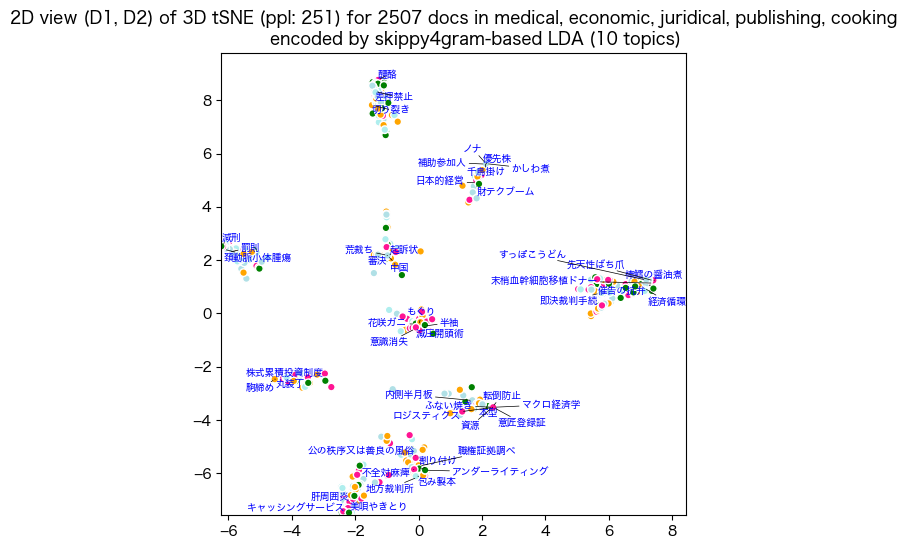

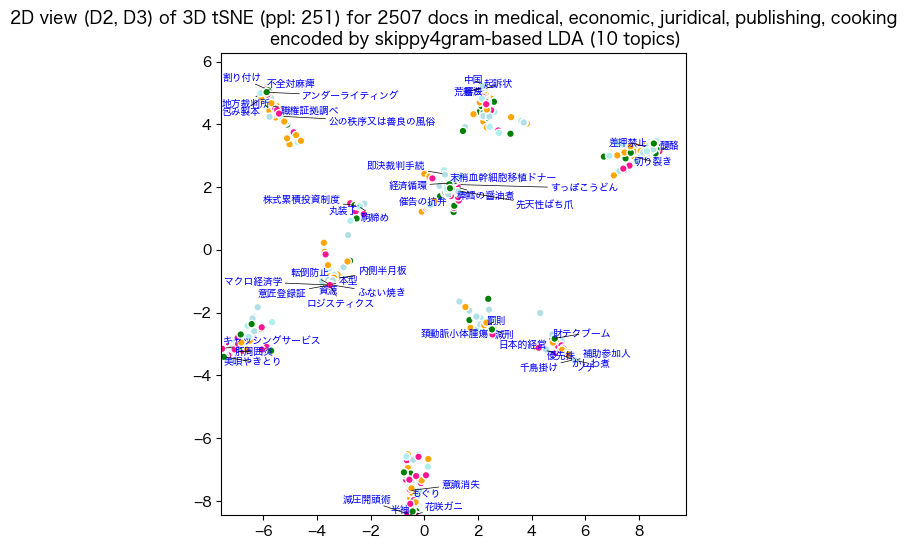

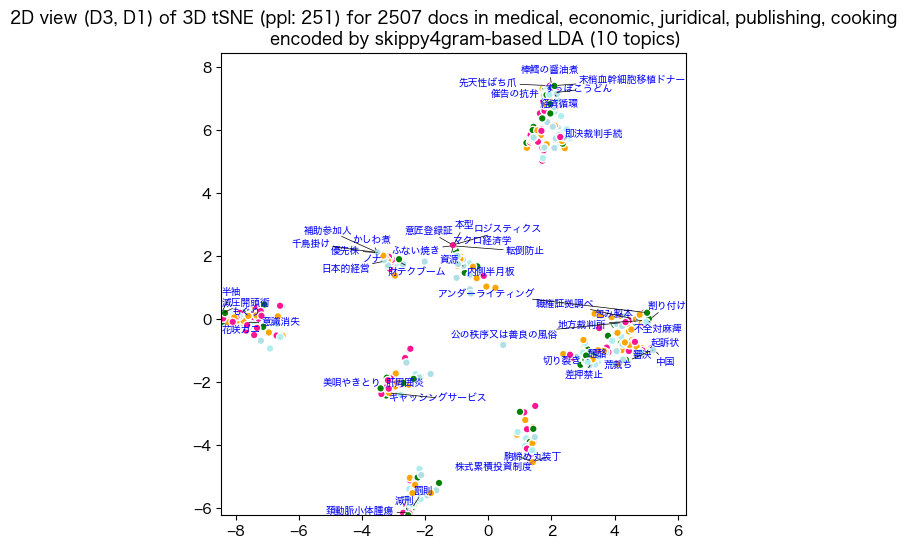

In [1359]:
%%capture --no-display

## tSNE の結果の可視化
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 文字を表示する事例のサンプリング
relative = True
lab_sampling_rate = 0.02 # サンプリング率の指定
if relative:
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定
print(f"lab_sample_n: {lab_sample_n}")

## labels の生成
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]
##
for i in range(3):
    roll = np.roll([0,1,2], -i)
    asp1, asp2 = roll[0], roll[1]
    X, Y = doc_tSNE_3d[:, asp1], doc_tSNE_3d[:, asp2]
    
    ## 
    plt.figure(figsize = (6, 6))
    plt.xlim(X.min(), X.max() + 1)
    plt.ylim(Y.min(), Y.max() + 1)

    ## 分野ごとの色分け
    #scatter = plt.scatter(X, Y, s = 30, c = 'r', edgecolors = 'w')
    cmap = list(map(lambda i: colormap[i], df['domain_id'])) # colormap は最初に定義してある
    scatter = plt.scatter(X, Y, s = 30, c = cmap, edgecolors = 'w')
    
    ##
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    get_Float_object_is_not_subsriptable_Error = False
    if get_Float_object_is_not_subsriptable_Error:
        pass
    else:
        adjust_text(texts,
                    expand_points = (1, 1), expand_text = (1, 1),
                    force_points = 0.2,
                    force_text = 0.2,
                    arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"2D view (D{asp1+1}, D{asp2+1}) of 3D tSNE (ppl: {doc_perplexity_val}) for {len(df)} docs in {', '.join(selected_domains.keys())}\n\
        encoded by {term_type}-based LDA ({n_topics} topics)")
    plt.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: ピンク Pink
## 経済用語:    オレンジ Orange
## 法律用語:    緑 Green
## 出版用語:    明るい緑 Pale Turquoise
## 調理用語:    小麦色 wheat
## その他:      灰色 gray

DBSCAN でクラスタリング

In [1360]:
## DBSCAN でクラスタリング
from sklearn.cluster import DBSCAN

## eps は事例ごとに調節が必要
eps_val = 0.7; min_samples_val = 2
D_clustered = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(doc_tSNE_3d)

## cluster id の取得
cluster_ids = D_clustered.labels_
np.unique(cluster_ids)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [1361]:
## 必要に応じて Seaborn を道入
#!pip install -U seaborn

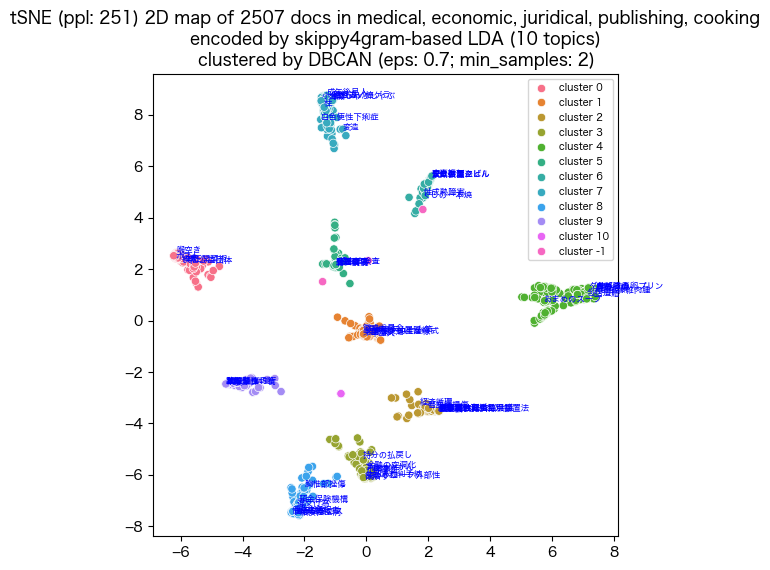

In [1362]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
d1, d2 = doc_tSNE_3d[:,0], doc_tSNE_3d[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in cluster_ids ])

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.03 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
label_size = max_doc_length
sampled_keys = [ x[:label_size] for x in random.sample(list(df[doc_type]), lab_sample_n) ]

texts = [ ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 6, color = 'blue'))

## 題名を指定
plt.title(f"tSNE (ppl: {doc_perplexity_val}) 2D map of {len(df)} docs in {', '.join(selected_domains.keys())}\n\
    encoded by {term_type}-based LDA ({n_topics} topics)\n\
    clustered by DBCAN (eps: {eps_val}; min_samples: {min_samples_val})")
#
plt.show()

## DBSCAN で局所化の効果は確認できる
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

階層クラスタリングのための再サンプリング

In [1363]:
## 階層クラスタリングのための事例サンプリング
doc_sampling_rate = 0.15 # 変更可能: 大きくし過ぎると図が見にくい
df_size = len(df_filtered)
if df_size > 600:
    df_sampled = df_filtered.sample(round(df_size * doc_sampling_rate), replace = False)
else:
    df_sampled = df_filtered
##
print(f"{len(df_sampled)} rows are sampled (preservation rate: {len(df_sampled)/len(df_filtered):0.3f})")

375 rows are sampled (preservation rate: 0.150)


In [1364]:
## domain 事例数の確認
df_sampled['domain_id'].value_counts().sort_index()

domain_id
0    80
2    77
3    73
4    76
5    69
Name: count, dtype: int64

階層クラスタリング

In [1365]:
## Plotly が必要な場合に実行
#!pip install -U plotly

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_4130/255126042.py:32: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



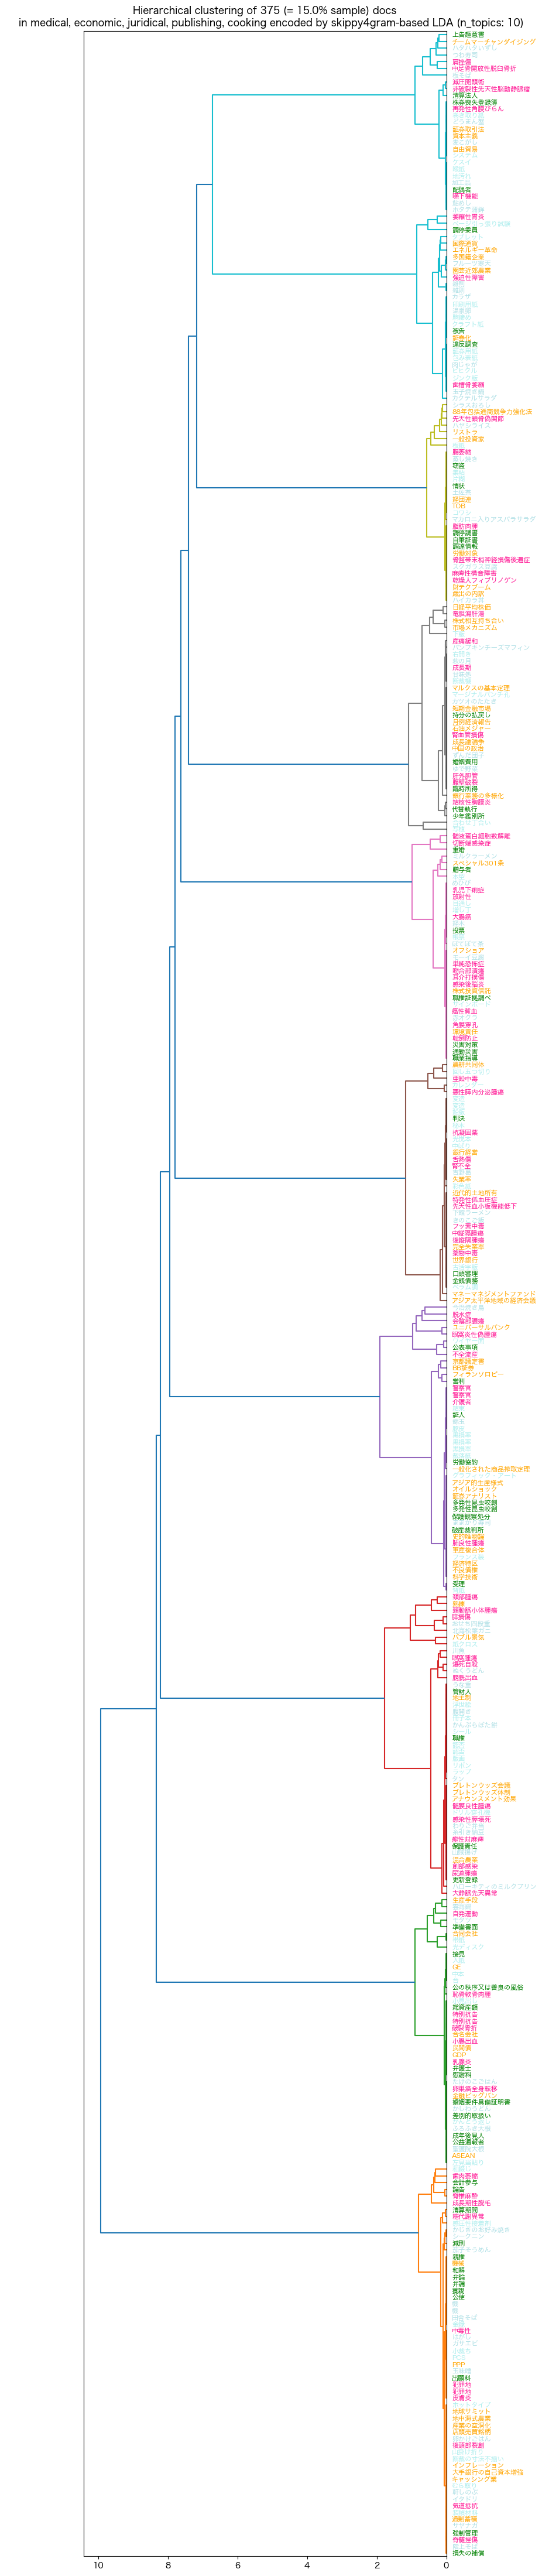

In [1366]:
## doc 階層クラスタリングの実行

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定
import plotly

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_linkage = linkage(list(df_sampled['enc']), method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (8, round(10 * len(df_sampled) * 0.015))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_length] for x in list(df_sampled[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of {len(df_sampled)} (= {100 * doc_sampling_rate}% sample) docs\n\
    in {', '.join(selected_domains.keys())} encoded by {term_type}-based LDA (n_topics: {n_topics})")

## ラベルに domain に対応する色を付ける
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    word = ticker.get_text()
    row = df_sampled.loc[df_sampled[doc_type] == word]
    try:
        domain_id = int(row['domain_id'])
    except TypeError:
        pass
    #ticker.set_color(plotly.colors.qualitative.Plotly[domain_id + 1]) # id の基数調整
    ticker.set_color(colormap[domain_id]) # id の基数調整
#
plt.show()

## * 配色 *
## 医学用語:    濃いピンク DeepPink
## 医療縮約表現: 赤 Pink
## 経済用語:    オレンジ Orange
## 法律用語:    緑 Green
## 出版用語:    明るい緑 Pale Turquoise
## 調理用語:    小麦色 PowderBlue
## その他:      灰色 gray